# Sentiment Classification (Binary) on Imdb Review Dataset

In [1]:
# Imports

import sys
import os
import re
import importlib
import numpy as np
from datetime import datetime
from bunch import Bunch
from sklearn.utils import shuffle
import torch
import torch.nn as nn

%matplotlib inline
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
from helpers.dataset import Dataset

glove_file = 'C:\\Workspace\\Git\\Data\\glove.6B\\glove.6B.100d.txt'
data_root = 'C:\\Workspace\\Git\\Data\\aclImdb'
categories = ['neg', 'pos']

# Load dataset
ds = Dataset(num_classes=2)
print('[{}] Loading data ...'.format(datetime.now()))
ds.load_dataset_from_dir(os.path.join(data_root, 'train'), os.path.join(data_root, 'test'), categories)

print('[{}] Building vocab and loading glove embeddings ...'.format(datetime.now()))
ds.build_vocab()
ds.load_word_embeddings(glove_file)

print('[{}] Creating X, y sequences ...'.format(datetime.now()))
ds.compute_Xy()

print('[{}] Padding X, y sequences ...'.format(datetime.now()))
ds.pad_Xy(fixed_max_len=30)

[2019-11-10 12:06:10.433621] Loading data ...
[2019-11-10 12:13:36.041301] Building vocab and loading glove embeddings ...
[2019-11-10 12:13:48.744785] Creating X, y sequences ...
[2019-11-10 12:13:54.511995] Padding X, y sequences ...


In [3]:
def print_stats(ds):

    print('Number of Raw Training records: {} examples, {} labels '.format(
        len(ds.raw_train.data), len(ds.raw_train.target)))
    print('Number of Raw Test records: {} examples, {} labels '.format(
        len(ds.raw_test.data), len(ds.raw_test.target)))
    print('Target Names:', ds.raw_train.target_names)

    print('Label distribution in Training Set')
    print(np.asarray(np.unique(ds.raw_train.target, return_counts=True)).T)
    print('Label distribution in Test Set')
    print(np.asarray(np.unique(ds.raw_test.target, return_counts=True)).T)

    print('Vocab Size: ', len(ds.vocab))
    print('shape(word_embeddings): ', ds.word_embeddings.shape)
    print('Top 5 Words in word2index map', ['{}({})'.format(w, i) for w, i in ds.word2index.items() if i <= 5])

    print('shape(ds.X_train) = ', ds.X_train.shape, ' dtype(ds.X_train) = ', ds.X_train.dtype)
    print('shape(ds.y_train) = ', ds.y_train.shape, ' dtype(ds.y_train) = ', ds.y_train.dtype)
    print('shape(ds.X_test) = ', ds.X_test.shape, ' dtype(ds.X_test) = ', ds.X_test.dtype)
    print('shape(ds.y_test) = ', ds.y_test.shape, ' dtype(ds.y_test) = ', ds.y_test.dtype)

    print('Top 5 training examples:')
    for i in range(5):
        print('[#{}]\t {}'.format(i + 1, ds.y_train[i]))
        print('\t', ds.X_train[i][:10])
        print('\t', ' '.join(ds.raw_train.data[i].split()[:30]))
        
print_stats(ds)

Number of Raw Training records: 25000 examples, 25000 labels 
Number of Raw Test records: 25000 examples, 25000 labels 
Target Names: ['neg', 'pos']
Label distribution in Training Set
[[    0 12500]
 [    1 12500]]
Label distribution in Test Set
[[    0 12500]
 [    1 12500]]
Vocab Size:  53858
shape(word_embeddings):  (46197, 100)
Top 5 Words in word2index map ['$PAD$(0)', '$UNK$(1)', 'the(2)', 'of(3)', 'to(4)', 'and(5)']
shape(ds.X_train) =  (25000, 30)  dtype(ds.X_train) =  int64
shape(ds.y_train) =  (25000, 1)  dtype(ds.y_train) =  int32
shape(ds.X_test) =  (25000, 30)  dtype(ds.X_test) =  int64
shape(ds.y_test) =  (25000, 1)  dtype(ds.y_test) =  int32
Top 5 training examples:
[#1]	 [0]
	 [4904  339 2920  339   11    2  174   65    3    2]
	 silent night deadly night is the very last of the series and like part it s unrelated to the first three except by title and the fact that it s
[#2]	 [1]
	 [    2  1072 24523     7   174   595   295    14     7   494]
	 the idea ia a very short

In [4]:
maxN = min(10000, len(ds.X_train)) 
split = int(0.7 * maxN)

offset = 5000

X_train = ds.X_train[offset:offset+split]
y_train = ds.y_train[offset:offset+split]
X_train_seqlen = ds.X_train_seqlen[offset:offset+split]

X_val = ds.X_train[offset+split:offset+maxN]
y_val = ds.y_train[offset+split:offset+maxN]
X_val_seqlen = ds.X_train_seqlen[offset+split:offset+maxN]

word_embeddings = ds.word_embeddings

print('shape(X_train) = ', X_train.shape, ' dtype(X_train) = ', X_train.dtype)
print('shape(y_train) = ', y_train.shape, ' dtype(y_train) = ', y_train.dtype)
print('shape(X_val) = ', X_val.shape, ' dtype(X_val) = ', X_val.dtype)
print('shape(y_val) = ', y_val.shape, ' dtype(y_val) = ', y_val.dtype)
    
print('Label distribution in Training Set')
print(np.asarray(np.unique(y_train, return_counts=True)).T)
print('Label distribution in Validation Set')
print(np.asarray(np.unique(y_val, return_counts=True)).T)

shape(X_train) =  (7000, 30)  dtype(X_train) =  int64
shape(y_train) =  (7000, 1)  dtype(y_train) =  int32
shape(X_val) =  (3000, 30)  dtype(X_val) =  int64
shape(y_val) =  (3000, 1)  dtype(y_val) =  int32
Label distribution in Training Set
[[   0 3532]
 [   1 3468]]
Label distribution in Validation Set
[[   0 1483]
 [   1 1517]]


In [9]:
config = Bunch()
config.vocab_size, config.embed_size = word_embeddings.shape
config.batch_size = 64
config.lr = 0.001
config.hidden_size = 50
config.num_lstm_layers = 2
config.dropout_p = 0.5
config.isBidirectional = True
config.output_size = 1

In [10]:
from helpers.utils import mini_batches
from helpers.TextRNN import TextRNN
from helpers.evaluate import evaluate_model
import torch.optim as optim

model = TextRNN(config, torch.from_numpy(word_embeddings).type(torch.FloatTensor))

optimizer = optim.Adam(model.parameters(), lr=config.lr)
loss_op = nn.BCELoss()  # binary cross entropy loss

model.set_optimizer(optimizer)
model.set_loss_op(loss_op)

epoch_losses = []
epoch_metrics = []
train_losses = []
val_losses = []

In [11]:
def reduce_lr(optimizer):
    for g in optimizer.param_groups:
        g['lr'] = g['lr'] / 2

for epoch in range(10):
        
    #X_train, y_train, X_train_seqlen = shuffle(X_train, y_train, X_train_seqlen, random_state=17)
    epoch_loss = model.run_epoch(X_train, y_train, X_train_seqlen)
    
    accuracy1, correct1, total1, loss1 = evaluate_model(model, X_train, y_train, X_train_seqlen, config.batch_size)
    accuracy2, correct2, total2, loss2 = evaluate_model(model, X_val, y_val, X_val_seqlen, config.batch_size)
    
    epoch_losses.append(epoch_loss)
    train_losses.append(loss1)
    val_losses.append(loss2)
    epoch_metrics.append('Training: {:.3f}% (={}/{}) L={:.5f}, Validation: {:.3f}% (={}/{}), L={:.5f}'.format(
        accuracy1, correct1, total1, loss1, accuracy2, correct2, total2, loss2))
    print('Epoch: {}, Loss: {:.8f}, {}'.format(epoch+1, epoch_losses[-1], epoch_metrics[-1]))
    
    if epoch % 3 == 0:
        reduce_lr(model.optimizer)
        print('Updated Learning Rate = ', set(g['lr'] for g in model.optimizer.param_groups))

Epoch: 1, Loss: 0.68492922, Training: 62.600% (=4382/7000) L=0.65252, Validation: 63.900% (=1917/3000), L=0.65190
Updated Learning Rate =  {0.0005}
Epoch: 2, Loss: 0.63917352, Training: 66.643% (=4665/7000) L=0.61315, Validation: 66.900% (=2007/3000), L=0.61534
Epoch: 3, Loss: 0.60677087, Training: 68.086% (=4766/7000) L=0.58971, Validation: 67.867% (=2036/3000), L=0.59589
Epoch: 4, Loss: 0.58206842, Training: 70.714% (=4950/7000) L=0.56565, Validation: 69.533% (=2086/3000), L=0.57718
Updated Learning Rate =  {0.00025}
Epoch: 5, Loss: 0.56787539, Training: 71.014% (=4971/7000) L=0.55104, Validation: 70.333% (=2110/3000), L=0.56798
Epoch: 6, Loss: 0.55466367, Training: 71.543% (=5008/7000) L=0.54209, Validation: 70.633% (=2119/3000), L=0.56553
Epoch: 7, Loss: 0.54951194, Training: 72.386% (=5067/7000) L=0.53412, Validation: 70.400% (=2112/3000), L=0.56397
Updated Learning Rate =  {0.000125}
Epoch: 8, Loss: 0.54105540, Training: 72.943% (=5106/7000) L=0.52997, Validation: 70.733% (=2122/

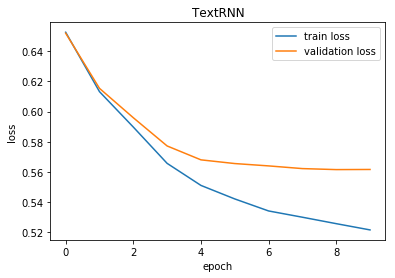

In [12]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('TextRNN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()

In [13]:
accuracy, correct, total, loss = evaluate_model(model, ds.X_test, ds.y_test, ds.X_test_seqlen, config.batch_size)
metric = '{:.3f}% (={}/{}) L={:.5f}'.format(accuracy, correct, total, loss)
print('Test Set Metric: ', metric)

Test Set Metric:  69.380% (=17345/25000) L=0.56753


In [14]:
from helpers.evaluate import predict_instance

for text in ['this is a good movie', 'this is worst movie i have seen']:
    lbl, score = predict_instance(model, ds, text)
    print('LABEL = {}, SCORE={:.4f}, INPUT = {}'.format(lbl, score, text))

LABEL = 1, SCORE=0.7939, INPUT = this is a good movie
LABEL = 0, SCORE=0.0678, INPUT = this is worst movie i have seen


In [15]:
## Understand Operations

word_emb = torch.tensor([
    [0,0,0,0,0],
    [1,1,1,1,1],
    [2,2,2,2,2],
    [3,3,3,3,3],
    [4,4,4,4,4],
    [5,5,5,5,5],
    [6,6,6,6,6],
    [7,7,7,7,7],
    [8,8,8,8,8]]).type(torch.FloatTensor)

embeddings = nn.Embedding(num_embeddings=9, embedding_dim=5, padding_idx=0)   # V * d
embeddings.weight = nn.Parameter(word_emb, requires_grad=False)

lstm = nn.LSTM(input_size=5, hidden_size=7, num_layers=2, batch_first=True, bidirectional=True)

X = torch.tensor([[2,3,4],[6,7,0]]).type(torch.LongTensor)

print('X = ')
print(X)
eX = embeddings(X)
print('eX = ')
print(eX)
l_o, (h_n, c_n) = lstm(eX)
print('h_n = ')
print(h_n)
fi = torch.cat([h_n[i, :, :] for i in range(h_n.shape[0])], dim=1)
print('fi = ')
print(fi)
fv = h_n.view(-1, h_n.size()[0] * h_n.size()[2])
print('fv = ')
print(fv)

X = 
tensor([[2, 3, 4],
        [6, 7, 0]])
eX = 
tensor([[[2., 2., 2., 2., 2.],
         [3., 3., 3., 3., 3.],
         [4., 4., 4., 4., 4.]],

        [[6., 6., 6., 6., 6.],
         [7., 7., 7., 7., 7.],
         [0., 0., 0., 0., 0.]]])
h_n = 
tensor([[[-2.4581e-02, -1.5646e-01, -4.1854e-01,  1.1983e-02,  3.0931e-01,
           5.4605e-02,  2.6043e-02],
         [-5.3601e-02,  5.8821e-03, -2.9429e-01,  4.5961e-02,  8.2807e-02,
           3.1934e-02,  2.8986e-01]],

        [[ 2.1519e-01, -5.5474e-02, -1.9238e-02, -6.1775e-02, -2.1234e-01,
          -2.5426e-01,  3.4827e-01],
         [ 2.3435e-02, -3.4006e-02,  2.7264e-04, -5.4775e-02, -8.0824e-02,
           2.2759e-01,  4.4715e-01]],

        [[ 1.6423e-01,  2.7814e-01,  1.4377e-01, -1.0311e-01, -1.9595e-01,
          -1.3976e-01,  1.4554e-01],
         [ 1.5868e-01,  3.2230e-01,  1.6522e-01, -7.2588e-02, -2.3054e-01,
          -1.5166e-01,  1.2723e-01]],

        [[-7.3470e-02,  1.3351e-01,  7.1375e-02,  1.5780e-01, -1.7534e-02,
